In [3]:
from os.path import join, abspath, expanduser
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import datetime

In [4]:
def correct_utm_to_wgs84(df):
    df_wgs84 = gpd.GeoDataFrame()
    for zone in df['utm_zone'].unique():
        sub = df[df.utm_zone == zone]
        epsg = 26900 + zone
        sub = sub.set_crs(epsg = epsg, allow_override=True).to_crs(epsg = 4326)
        df_wgs84 = df_wgs84.append(sub)
    df_wgs84 = df_wgs84.set_geometry('geom', crs = 4326)
    return df_wgs84

## Database section

In [5]:
#database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas

# Import the connection function from the snowexsql library
from snowexsql.db import get_db

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

In [6]:
# Find all the snow pits done on these days 
qry = session.query(SiteData.geom, SiteData.site_id, SiteData.date, SiteData.id, SiteData.aspect, SiteData.site_name, SiteData.total_depth, SiteData.tree_canopy)

# Return a geopandas df
df_range = query_to_geopandas(qry, engine)
df_db = df_range.sort_values('date')
df_db

,geom,site_id,date,id,aspect,site_name,total_depth,tree_canopy
357,POINT (424563.096 4417714.719),JPL 2,2019-10-24,358,NaN,Fraser Experimental Forest,NaN,No Trees
336,POINT (424541.156 4417657.215),JPL 1,2019-10-24,337,NaN,Fraser Experimental Forest,NaN,No Trees
358,POINT (424562.208 4417711.397),JPL 2,2019-10-29,359,NaN,Fraser Experimental Forest,NaN,No Trees
337,POINT (424542.810 4417651.648),JPL 1,2019-10-29,338,NaN,Fraser Experimental Forest,NaN,No Trees
338,POINT (424540.213 4417648.344),JPL 1,2019-11-24,339,NaN,Fraser Experimental Forest,NaN,No Trees
...,...,...,...,...,...,...,...,...
525,POINT (453356.066 4431402.104),Forest Flat,2020-05-13,526,NaN,Niwot Ridge,NaN,Open (20-70%)
551,POINT (452490.101 4432369.805),Forest South,2020-05-13,552,180.0,Niwot Ridge,NaN,Closed (>70%)
565,POINT (452914.349 4431857.692),Open Flat,2020-05-13,566,NaN,Niwot Ridge,NaN,No Trees
548,POINT (452496.108 4432375.317),Forest South,2020-05-13,549,180.0,Niwot Ridge,NaN,Open (20-70%)


In [5]:
# Find all the snow pits done on these days 
qry = session.query(PointData.site_name, PointData.date, PointData.geom, PointData.time, PointData.units, PointData.utm_zone, )
qry = qry.filter(PointData.instrument != 'Mala 800 MHz GPR')
qry = qry.filter(PointData.type == 'depth')
qry = qry.filter(PointData.site_name != 'Grand Mesa')
qry = qry.limit(200)
# Return a geopandas df
df_range = query_to_geopandas(qry, engine)
df_range

,site_name,date,geom,time,units,utm_zone


In [8]:
import datetime
# Find all the data that was collected on 2-12-2020
dt = datetime.date(2020, 2, 12)

#--------------- Point Data -----------------------------------
# Grab all Point data instruments from our date
point_instruments = session.query(PointData.instrument).filter(PointData.date == dt).distinct().all()
point_type = session.query(PointData.type).filter(PointData.date == dt).distinct().all()

# Clean up point data (i.e. remove tuple)
point_instruments = [p[0] for p in point_instruments if p[0] is not None]
point_instruments = ", ".join(point_instruments)
point_type = [p[0] for p in point_type]
point_type = ", ".join(point_type)
print('Point data on %s are: %s, with the following list of parameters: %s' %(str(dt), point_instruments, point_type))

#--------------- Layer Data -----------------------------------
# Grab all Layer data instruments from our date
layer_instruments = session.query(LayerData.instrument).filter(LayerData.date == dt).distinct().all()
layer_type = session.query(LayerData.type).filter(LayerData.date == dt).distinct().all()

# Clean up layer data 
layer_instruments = [l[0] for l in layer_instruments if l[0] is not None]
layer_instruments = ", ".join(layer_instruments)
layer_type = [l[0] for l in layer_type]
layer_type = ", ".join(layer_type)
print('\nLayer Data on %s are: %s, with the following list of parameters: %s' %(str(dt), layer_instruments, layer_type))

#--------------- Image Data -----------------------------------
# Grab all Image data instruments from our date
image_instruments = session.query(ImageData.instrument).filter(ImageData.date == dt).distinct().all()
image_type = session.query(ImageData.type).filter(ImageData.date == dt).distinct().all()

# Clean up image data 
image_instruments = [i[0] for i in image_instruments]
image_instruments = ", ".join(image_instruments)
image_type = [i[0] for i in image_type if i[0] is not None]
image_type = ", ".join(image_type)
print('\nImage Data on %s are: %s, with the following list of parameters: %s' %(str(dt), image_instruments, image_type))

Point data on 2020-02-12 are: camera, magnaprobe, pit ruler, with the following list of parameters: depth

Layer Data on 2020-02-12 are: IRIS, IS3-SP-11-01F, snowmicropen, with the following list of parameters: density, equivalent_diameter, force, grain_size, grain_type, hand_hardness, lwc_vol, manual_wetness, permittivity, reflectance, sample_signal, specific_surface_area, temperature

Image Data on 2020-02-12 are: UAVSAR, L-band InSAR, with the following list of parameters: insar amplitude, insar correlation, insar interferogram imaginary, insar interferogram real


In [12]:
from rio_geom import rio_to_exterior
from datetime import timedelta
import geopandas as gpd
import contextily as ctx

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

res = pd.DataFrame()
for i, image_fp in enumerate(image_fps):
    if i == i:
        dic = {}
        loc = image_fp['location']
        dic['loc'] = loc
        if image_fp['flight1'].date().year == 2021 or image_fp['pol'] != 'HH':
            pass
        else:
            geom = rio_to_exterior(image_fp['cor'])
            for i, dt in enumerate(['flight1', 'flight2']):
                dic[f't{i+1}'] = image_fp[dt]
                dt = image_fp[dt].date()
                # Form a date range to query on either side of our chosen day 
                date_range = [dt + i * timedelta(days=1) for i in [-1, 0, 1]]

                # Find all the snow pits done on these days 
                qry = session.query(PointData.site_name, PointData.date, PointData.geom, PointData.time, PointData.units, PointData.utm_zone, PointData.value)
                qry = qry.filter(PointData.instrument != 'Mala 800 MHz GPR')
                qry = qry.filter(PointData.type == 'depth')

                # qry = session.query(SiteData.geom, SiteData.site_id, SiteData.date)
                qry = qry.filter(PointData.date.in_(date_range))

                # Return a geopandas df
                df_range = query_to_geopandas(qry, engine)
                df_range = correct_utm_to_wgs84(df_range)
                if len(df_range) > 0:
                    # View snow pits that are +/- 1 day of the first UAVSAR flight date
                    geom = geom.to_crs(df_range.crs)
                    points_within = gpd.sjoin(df_range, geom, predicate='within')
                    dic[f't{i+1}_pit_num'] = len(points_within)
                else:
                    dic[f't{i+1}_pit_num'] = len(points_within)
                    print(f'{dt}_{loc} has none')
            res = pd.concat([res, pd.DataFrame.from_dict([dic])])
            # f, ax= plt.subplots(figsize = (12,8))
            # print('{} to {} at {}'.format(dic['t1'], dic['t2'], loc))
            # geom.plot(ax = ax)
            # df_range.plot(ax= ax, color = 'red', zorder = 1)
            # ctx.add_basemap(ax = ax, crs = geom.crs, source = ctx.providers.Esri.NatGeoWorldMap)
            # plt.show()

In [10]:
from rio_geom import rio_to_exterior
from datetime import timedelta
import geopandas as gpd
import contextily as ctx

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

res = pd.DataFrame()
for i, image_fp in enumerate(image_fps):
    if i == i:
        dic = {}
        loc = image_fp['location']
        dic['loc'] = loc
        if image_fp['flight1'].date().year == 2021 or image_fp['pol'] != 'HH':
            pass
        else:
            geom = rio_to_exterior(image_fp['cor'])
            for i, dt in enumerate(['flight1', 'flight2']):
                dic[f't{i+1}'] = image_fp[dt]
                dt = image_fp[dt].date()
                # Form a date range to query on either side of our chosen day 
                date_range = [dt + i * timedelta(days=1) for i in [-1, 0, 1]]

                # Find all the snow pits done on these days 
                qry = session.query(LayerData.bottom_depth, LayerData.date, LayerData.depth, LayerData.geom, LayerData.instrument, LayerData.type, LayerData.id, LayerData.value, LayerData.site_name, LayerData.site_id, LayerData.easting, LayerData.northing, LayerData.utm_zone)
                qry = qry.filter(LayerData.type == 'lwc_vol')
                # qry = session.query(SiteData.geom, SiteData.site_id, SiteData.date)
                qry = qry.filter(LayerData.date.in_(date_range))

                # Return a geopandas df
                df_range = query_to_geopandas(qry, engine)
                df_range = correct_utm_to_wgs84(df_range)
                if len(df_range)>0:
                    # View snow pits that are +/- 1 day of the first UAVSAR flight date
                    geom = geom.to_crs(df_range.crs)
                    points_within = gpd.sjoin(df_range, geom, predicate='within')
                    dic[f't{i+1}_pit_num'] = len(points_within)
                    # f, ax= plt.subplots(figsize = (12,8))
                    # geom.plot(ax = ax)
                    # df_range.plot(ax= ax, color = 'red', zorder = 1)
                    # print('{} vs {}'.format(geom.crs, df_range.crs))
                    # ctx.add_basemap(ax = ax, crs = df_range.crs)
                    # plt.show()
                else:
                    dic[f't{i+1}_pit_num'] = len(points_within)
                    print(f'{dt}_{loc} has none')
            res = pd.concat([res, pd.DataFrame.from_dict([dic])])

In [ ]:
from rio_geom import rio_to_exterior
from datetime import timedelta
import geopandas as gpd
import contextily as ctx

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

res = pd.DataFrame()
for i, image_fp in enumerate(image_fps):
    if i == i:
        dic = {}
        loc = image_fp['location']
        dic['loc'] = loc
        if image_fp['flight1'].date().year == 2021 or image_fp['pol'] != 'HH':
            pass
        else:
            geom = rio_to_exterior(image_fp['cor'])
            for i, dt in enumerate(['flight1', 'flight2']):
                dic[f't{i+1}'] = image_fp[dt]
                dt = image_fp[dt].date()
                # Form a date range to query on either side of our chosen day 
                date_range = [dt + i * timedelta(days=1) for i in [-1, 0, 1]]

                # Find all the snow pits done on these days 
                qry = session.query(SiteData.geom, SiteData.site_id, SiteData.date, SiteData.id, SiteData.aspect, SiteData.site_name, SiteData.total_depth, SiteData.tree_canopy, SiteData.utm_zone, SiteData.ground_condition, SiteData.ground_roughness, SiteData.ground_vegetation, SiteData.slope_angle, SiteData.vegetation_height)

                # qry = session.query(SiteData.geom, SiteData.site_id, SiteData.date)
                qry = qry.filter(SiteData.date.in_(date_range))

                # Return a geopandas df
                df_range = query_to_geopandas(qry, engine)
                df_range = correct_utm_to_wgs84(df_range)
                if len(df_range)>0:
                    # View snow pits that are +/- 1 day of the first UAVSAR flight date
                    geom = geom.to_crs(df_range.crs)
                    points_within = gpd.sjoin(df_range, geom, predicate='within')
                    points_within = points_within.set_index('site_id')
                    dic[f't{i+1}_pit_num'] = len(points_within)
                    dic[f't{i+1}_pits'] = points_within
                    # f, ax= plt.subplots(figsize = (12,8))
                    # geom.plot(ax = ax)
                    # df_range.plot(ax= ax, color = 'red', zorder = 1)
                    # print('{} vs {}'.format(geom.crs, df_range.crs))
                    # ctx.add_basemap(ax = ax, crs = df_range.crs)
                    # plt.show()
                else:
                    dic[f't{i+1}_pit_num'] = len(points_within)
                    print(f'{dt}_{loc} has none')
            res = pd.concat([res, pd.DataFrame.from_dict([dic])])

In [12]:
res.iloc[12]['t1_pits']

,geom,date,id,aspect,site_name,total_depth,tree_canopy,utm_zone,ground_condition,ground_roughness,ground_vegetation,slope_angle,vegetation_height,index_right
site_id,,,,,,,,,,,,,,
2C12,POINT (-108.20077 39.05324),2020-02-12,1,NaN,Grand Mesa,90.0,No Trees,12,Frozen,Rough,Shrub,0.0,30,0
6S26,POINT (-108.16733 39.01840),2020-02-12,2,NaN,Grand Mesa,112.0,No Trees,12,Frozen,Smooth,"Grass, Shrub",NaN,"10, 60",0
5N32,POINT (-108.17169 39.03045),2020-02-12,3,NaN,Grand Mesa,102.0,No Trees,12,Frozen,Smooth,"Grass, Shrub",NaN,"20, 30",0
FL1B,POINT (-108.17417 39.02193),2020-02-12,4,NaN,Grand Mesa,100.0,No Trees,12,Frozen,Smooth,"Grass, Shrub",NaN,"10, 30",0
5N24,POINT (-108.18569 39.03295),2020-02-12,5,NaN,Grand Mesa,113.0,No Trees,12,Frozen,Rough,Shrub,0.0,34,0
1C5,POINT (-108.21556 39.06188),2020-02-12,6,NaN,Grand Mesa,82.0,No Trees,12,Frozen,Rugged,Shrub,0.0,35-75,0
2C13,POINT (-108.20091 39.04961),2020-02-12,7,NaN,Grand Mesa,81.0,No Trees,12,Frozen,Rugged,Shrub,0.0,35,0
1N23,POINT (-108.18638 39.03184),2020-02-11,118,NaN,Grand Mesa,68.0,No Trees,12,Frozen,Smooth,"Grass, Shrub",NaN,"18, 23",0
2N21,POINT (-108.18731 39.03210),2020-02-11,119,225.0,Grand Mesa,103.0,No Trees,12,Frozen,Smooth,Shrub,2.0,16,0


In [17]:
res.iloc[-1]['t1_pits']

,geom,date,id,aspect,site_name,total_depth,tree_canopy,utm_zone,ground_condition,ground_roughness,ground_vegetation,slope_angle,vegetation_height,index_right
site_id,,,,,,,,,,,,,,
Alta Collins,POINT (-111.62997 40.57210),2020-02-20,482,0.0,Little Cottonwood Canyon,None,No Trees,12,Moist,Smooth,Grass,0.0,None,0
Atwater,POINT (-111.63759 40.59125),2020-02-20,489,0.0,Little Cottonwood Canyon,None,No Trees,12,Frozen,Smooth,Grass,0.0,None,0


In [18]:
res.iloc[-1]['t2_pits']

,geom,date,id,aspect,site_name,total_depth,tree_canopy,utm_zone,ground_condition,ground_roughness,ground_vegetation,slope_angle,vegetation_height,index_right
site_id,,,,,,,,,,,,,,
Alta Collins,POINT (-111.62997 40.57210),2020-03-12,485,0.0,Little Cottonwood Canyon,None,No Trees,12,Frozen,Smooth,Grass,0.0,None,0
Atwater,POINT (-111.63759 40.59125),2020-03-12,492,0.0,Little Cottonwood Canyon,None,Sparse (5-20%),12,Frozen,Smooth,Grass,0.0,None,0


## testing geometreis

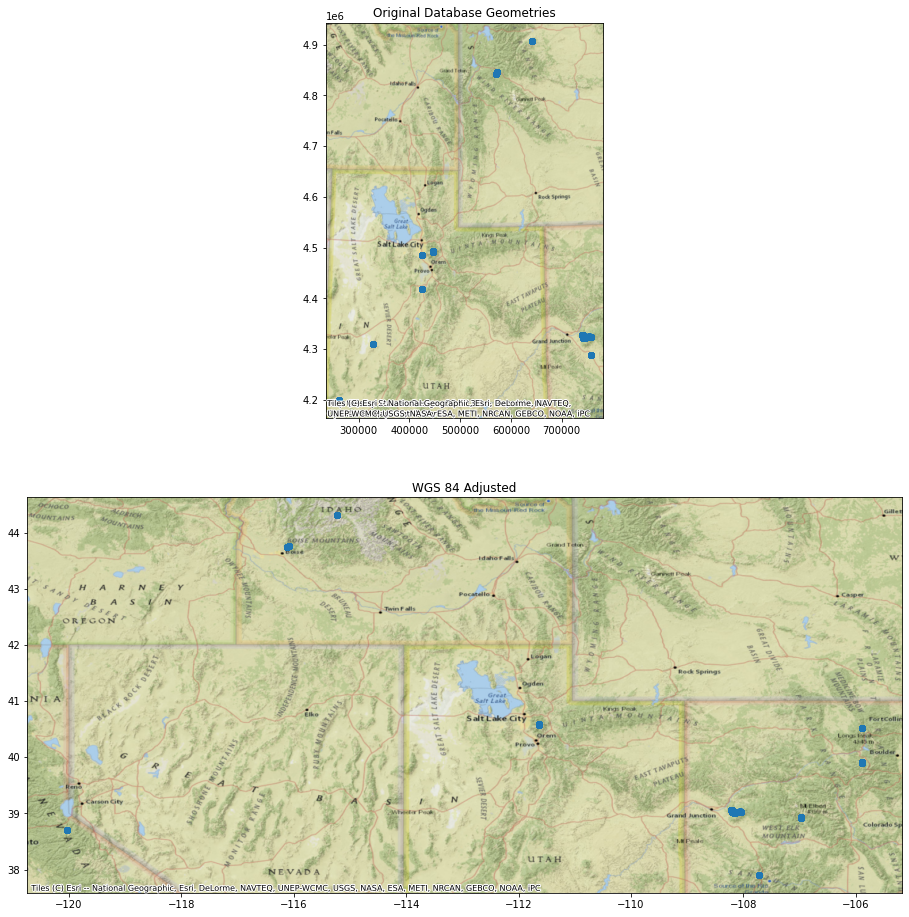

In [90]:
f, axes = plt.subplots(2, figsize = (24,16))
df_wgs84 = gpd.GeoDataFrame()
for zone in df_range['utm_zone'].unique():
    sub = df_range[df_range.utm_zone == zone]
    epsg = 26900 + zone
    sub = sub.set_crs(epsg = epsg, allow_override=True).to_crs(epsg = 4326)
    df_wgs84 = df_wgs84.append(sub)
df_wgs84 = df_wgs84.set_geometry('geom', crs = 4326)
for i, ax in enumerate(axes):
    if i == 0:
        df_range.plot(ax = ax)
        ctx.add_basemap(ax = ax, crs = df_range.crs)
        ctx.add_basemap(ax = ax, crs = df_range.crs, source = ctx.providers.Esri.NatGeoWorldMap)
        ax.set_title('Original Database Geometries')
    else:
        df_wgs84.plot(ax = ax)
        # ctx.add_basemap(ax = ax, crs = df_wgs84.crs)
        ctx.add_basemap(ax = ax, crs = df_wgs84.crs, source = ctx.providers.Esri.NatGeoWorldMap)
        ax.set_title('WGS 84 Adjusted')

plt.show()

## CSV part

In [20]:
data_dir = expanduser('~/scratch/data/uavsar/snowpits')
swe = pd.read_csv(join(data_dir, 'SNEX20_TS_SP_Summary_SWE_v01.csv'))
swe = swe.sort_values('Date/Local Standard Time')

env = pd.read_csv(join(data_dir, 'SNEX20_TS_SP_Summary_Environment_v01.csv'))
env = env.sort_values('Date/Local Standard Time')

In [43]:
swe[(swe.Location == 'Little Cottonwood Canyon') & (pd.to_datetime(swe['Date/Local Standard Time']).dt.date == datetime.date(2020,2,20))]

,Location,Site,PitID,Date/Local Standard Time,UTM Zone,Easting (m),Northing (m),Latitude (deg),Longitude (deg),Density A Mean (kg/m^3),Density B Mean (kg/m^3),Density Mean (kg/m^3),SWE A (mm),SWE B (mm),SWE (mm),Snow Depth (cm)
333,Little Cottonwood Canyon,Atwater,UTLCAW_20200220_1350,2020-02-20T13:50,12N,446048,4493579,40.59125,-111.63759,342,342,342.0,969,969,969.0,284.0
326,Little Cottonwood Canyon,Alta Collins,UTLCAC_20200220_1400,2020-02-20T14:00,12N,446677,4491448,40.57210,-111.62997,344,344,344.0,912,912,912.0,265.0


In [42]:
env[(env.Location == 'Little Cottonwood Canyon') & (pd.to_datetime(env['Date/Local Standard Time']).dt.date == datetime.date(2020,2,20))]

,Location,Site,PitID,Date/Local Standard Time,UTM Zone,Easting (m),Northing (m),Latitude (deg),Longitude (deg),Precipitation,Sky,Wind,Ground Condition,Ground Roughness,Ground Vegetation,Height of Ground Vegetation (cm),Canopy
335,Little Cottonwood Canyon,Atwater,UTLCAW_20200220_1350,2020-02-20T13:50,12N,446048,4493579,40.59125,-111.63759,None,Clear,Light,Frozen,Smooth,Grass,NaN,No Trees
328,Little Cottonwood Canyon,Alta Collins,UTLCAC_20200220_1400,2020-02-20T14:00,12N,446677,4491448,40.57210,-111.62997,None,Clear,Moderate,Moist,Smooth,Grass,NaN,No Trees
